In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, 
                             precision_recall_curve, plot_precision_recall_curve, f1_score, average_precision_score, 
                             hinge_loss, precision_score, recall_score, classification_report)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_breast_cancer, load_digits, fetch_openml, load_iris, make_moons, make_blobs
from sklearn.multiclass import OneVsRestClassifier
from scipy import stats
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
%matplotlib inline

### 1. Prezentacja o SVM

Link do prezentacji: https://1drv.ms/p/s!Ap19wJ6OUb8YgYMBlXjB0sOhyxqi0Q

### 2. Przykład działania SVM dla zbiorów WBC (WBreast cancer), MNIST, FMNIST - 500 elementów

In [2]:
# WBC
cancer = load_breast_cancer()

cancer_zipped = list(zip(cancer.data, cancer.target))
cancer_random_sample = random.sample(cancer_zipped, 500)
X, Y = zip(*(cancer_random_sample))
X = np.asarray(X)
Y = np.asarray(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.9)

clf = SVC(kernel='linear')
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(f'accuracy score: {accuracy_score(y_test,y_pred)}')

accuracy score: 0.94


In [3]:
# MNIST
mnist = fetch_openml("mnist_784", data_home="./mnist_784", cache=True)

mnist_zipped = list(zip(mnist.data, mnist.target))
mnist_random_sample = random.sample(mnist_zipped, 500)
X, Y = zip(*(mnist_random_sample))
X = np.asarray(X)
Y = np.asarray(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.9)

clf = SVC(kernel='linear')
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(f'accuracy score: {accuracy_score(y_test,y_pred)}')

accuracy score: 0.9


In [4]:
# FMNIST
fmnist = fetch_openml("Fashion-MNIST", data_home="./fmnist", cache=True)

fmnist_zipped = list(zip(fmnist.data, fmnist.target))
fmnist_random_sample = random.sample(fmnist_zipped, 500)
X, Y = zip(*(fmnist_random_sample))
X = np.asarray(X)
Y = np.asarray(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.9)

clf = SVC(kernel='linear')
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(f'accuracy score: {accuracy_score(y_test,y_pred)}')

accuracy score: 0.78


In [5]:
# Porównianie kerneli dla powyższych zbiorów. 

In [6]:
def accuracy(dataset, kernel):
    dataset_zipped = list(zip(dataset.data, dataset.target))
    dataset_random_sample = random.sample(dataset_zipped, 500)
    X, Y = zip(*(dataset_random_sample))
    X = np.asarray(X)
    Y = np.asarray(Y)

    x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.9)

    clf = SVC(kernel='linear')
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    
    return accuracy_score(y_test,y_pred)

In [7]:
frame_data = []

for kernel in ('linear', 'poly', 'rbf'):
    frame_data.append([kernel, accuracy(cancer, kernel), accuracy(mnist, kernel), accuracy(fmnist, kernel)])

                  
frame = pd.DataFrame(frame_data, columns=["kernel", "cancer", "mnist", "fmnist"])
frame

,kernel,cancer,mnist,fmnist
0,linear,0.94,0.84,0.66
1,poly,0.94,0.90,0.72
2,rbf,0.96,0.78,0.82


### 3. Krótkie ćwiczenie dla studentów, w którym należy dobrać odpowiednie parametry kernela i uczenia dla wybranych zbiorów danych

In [8]:
# Just util functions. Imagine it's not here :)

data_colors = [(1, 0, 0), (0, 0, 1)]

def read_points_file(filename):
    pts = []
    with open(filename, "r") as f:
        for pt in f:
            pt = pt.strip("\n").split()
            pts.append([float(pt[0]), float(pt[1])])
    return pts


def read_data(class_0_file, class_1_file):
    pts_0 = read_points_file(class_0_file)
    pts_1 = read_points_file(class_1_file)

    x = pts_0 + pts_1
    labels = [0] * len(pts_0) + [1] * len(pts_1)
    x = np.array(x)
    return (x, labels)


def plot_data(X_train, y_train, X_test, y_test):

    X = np.concatenate((X_train, X_test))
    y = np.concatenate((y_train, y_test))

    colors = get_colors(y)
    colors_train = get_colors(y_train)
    colors_test = get_colors(y_test)


    plt.figure(figsize=(12, 4))

    # Plot all data plot
    plt.subplot(131)
    plt.axis('equal')
    plt.scatter(X[:, 0], X[:, 1], c = colors, s = 10, edgecolors=colors)
    plt.title("Data (100%)")

    # training data plot
    plt.subplot(132)
    plt.axis('equal')
    plt.scatter(X_train[:, 0], X_train[:, 1], c = colors_train, s = 10, edgecolors=colors_train)
    plt.title("Training Data (80%)")

    # testing data plot
    plt.subplot(133)
    plt.axis('equal')
    plt.scatter(X_test[:, 0], X_test[:, 1], c = colors_test, s = 10, edgecolors=colors_test)
    plt.title("Test Data (20%)")
    plt.tight_layout()

    plt.show()

    
def get_colors(y):
    return [data_colors[int(item)] for item in y]


def plot_decision_function(X_train, y_train, X_test, y_test, clf):
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.title("Training data")
    plot_decision_function_helper(X_train, y_train, clf)
    plt.subplot(122)
    plt.title("Test data")
    plot_decision_function_helper(X_test, y_test, clf, True)
    plt.show()


def plot_decision_function_helper(X, y, clf, show_only_decision_function = False):
    colors = get_colors(y)
    plt.axis('equal')
    plt.tight_layout()

    plt.scatter(X[:, 0], X[:, 1], c = colors, s = 10, edgecolors=colors)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    
def generate_train_set(X,Y):
    return train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state = 42)


def do_svm(train_X, test_X, train_Y, test_Y, plot=True, **kwargs):
    clf = SVC(**kwargs)
    clf.fit(train_X, train_Y)
    y_pred = clf.predict(test_X)
    if plot:
        plot_decision_function(train_X, train_Y, test_X, test_Y, clf)
    print("Accuracy: " + str(accuracy_score(test_Y, y_pred)))

Zaobserwuj poniższy zbiór danych o dwóch cechach i w następnym kroku postaraj się wybrać odpowiednie parametry dla SVM

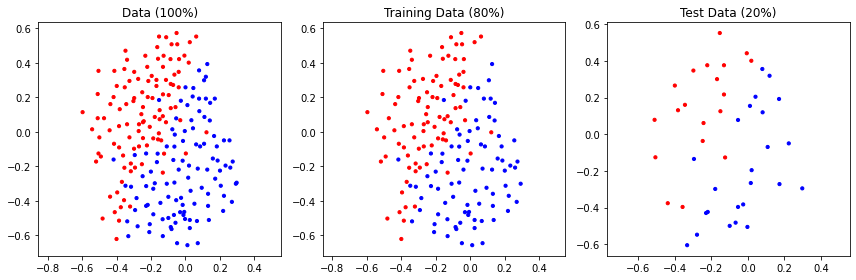

In [97]:
X, y = read_data("custom_datasets/1/points_class_0.txt", "custom_datasets/1/points_class_1.txt")
train_X, test_X, train_Y, test_Y = generate_train_set(X,y)
plot_data(train_X, train_Y, test_X, test_Y)

Wybierz dla powyższego zbioru odpowiednie parametry kernela oraz stałą uczenia, aby osiągnąć najlepszą dokładność. Wypróbuj wszystkie parametry, postaraj się zauważyć jak zmienia się wybrana hiperpłaszczyzna.

**Kernel** = wybierz jedno z: linear, poly, rbf, sigmoid

**C** = liczba rzeczywista

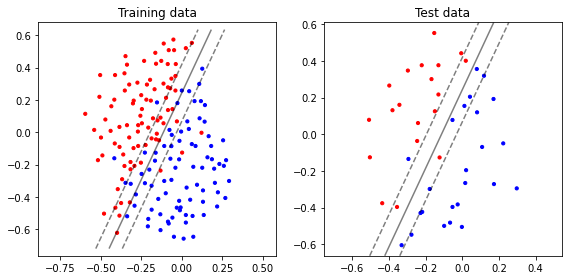

Accuracy: 0.9534883720930233


In [98]:
do_svm(train_X, test_X, train_Y, test_Y, kernel='linear', C=100)

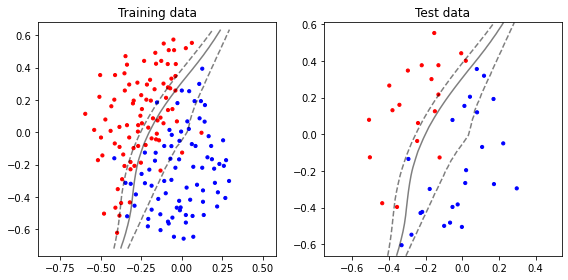

Accuracy: 0.9534883720930233


In [99]:
do_svm(train_X, test_X, train_Y, test_Y, kernel='poly', C=10)

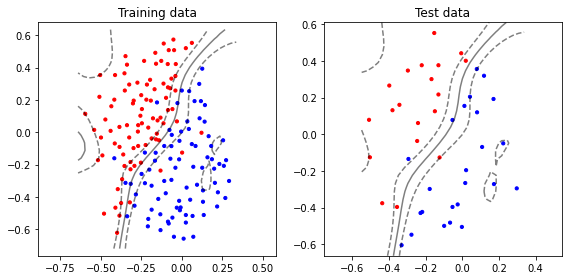

Accuracy: 0.9302325581395349


In [100]:
do_svm(train_X, test_X, train_Y, test_Y, kernel='rbf', C=100)

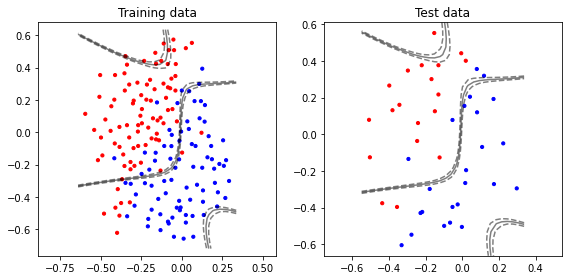

Accuracy: 0.8372093023255814


In [101]:
do_svm(train_X, test_X, train_Y, test_Y, kernel='sigmoid', C=10)

Zrób to samo co wcześniej, ale dla innego rodzaju danych

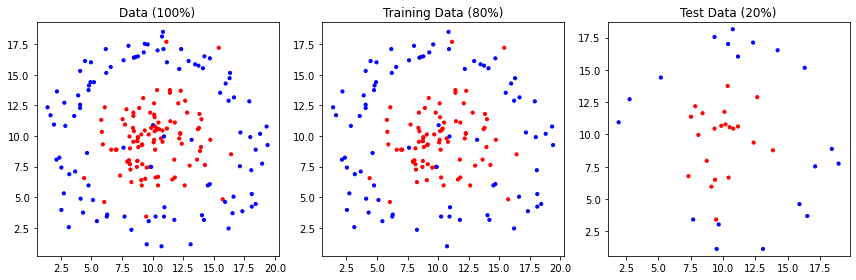

In [102]:
X, y = read_data("custom_datasets/2/points_class_0.txt", "custom_datasets/2/points_class_1.txt")
train_X, test_X, train_Y, test_Y = generate_train_set(X,y)
plot_data(train_X, train_Y, test_X, test_Y)

Wybierz dla powyższego zbioru odpowiednie parametry kernela oraz stałą uczenia, aby osiągnąć najlepszą dokładność.

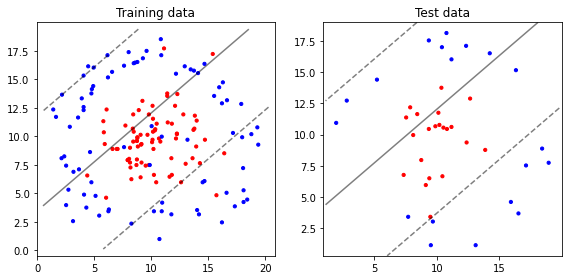

Accuracy: 0.65


In [103]:
do_svm(train_X, test_X, train_Y, test_Y, kernel='linear', C=10)

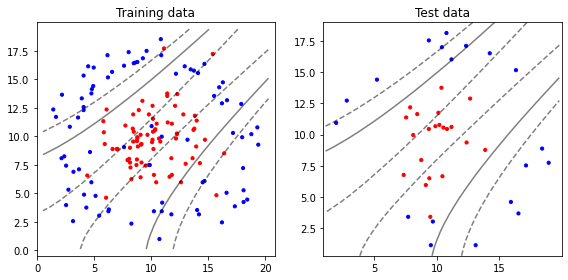

Accuracy: 0.875


In [104]:
do_svm(train_X, test_X, train_Y, test_Y, kernel='poly', C=1000)

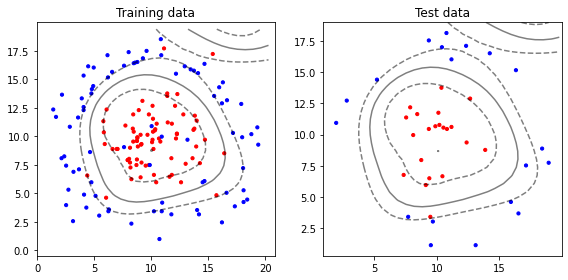

Accuracy: 0.975


In [105]:
do_svm(train_X, test_X, train_Y, test_Y, kernel='rbf', C=20)

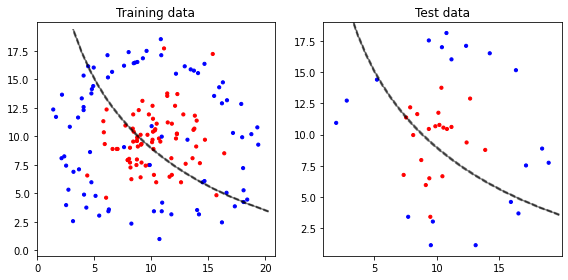

Accuracy: 0.45


In [106]:
do_svm(train_X, test_X, train_Y, test_Y, kernel='sigmoid', C=200)

Ostatni raz, zrób to samo co wcześniej, ale dla jeszcze innego rodzaju danych

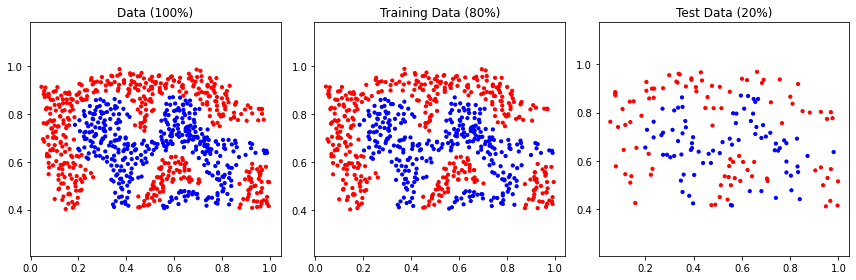

In [107]:
X, y = read_data("custom_datasets/3/points_class_0.txt", "custom_datasets/3/points_class_1.txt")
train_X, test_X, train_Y, test_Y = generate_train_set(X,y)
plot_data(train_X, train_Y, test_X, test_Y)

Wybierz dla powyższego zbioru odpowiednie parametry kernela oraz stałą uczenia, aby osiągnąć najlepszą dokładność.

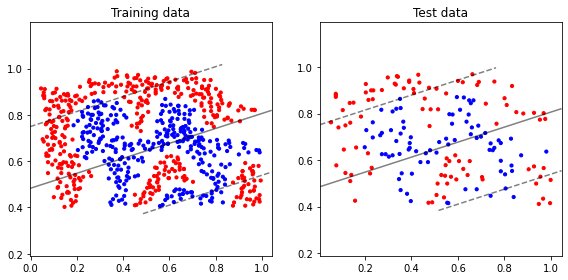

Accuracy: 0.5375722543352601


In [108]:
do_svm(train_X, test_X, train_Y, test_Y, kernel='linear', C=100)

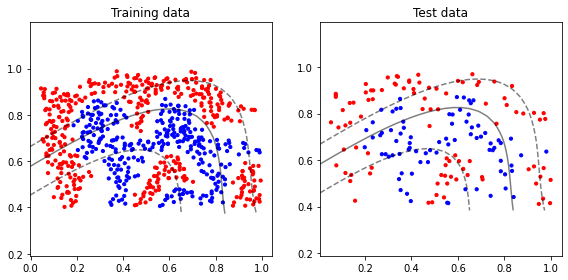

Accuracy: 0.7225433526011561


In [109]:
do_svm(train_X, test_X, train_Y, test_Y, kernel='poly', C=30)

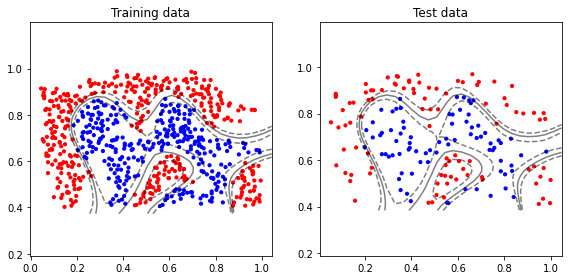

Accuracy: 0.9595375722543352


In [110]:
do_svm(train_X, test_X, train_Y, test_Y, kernel='rbf', C=300)

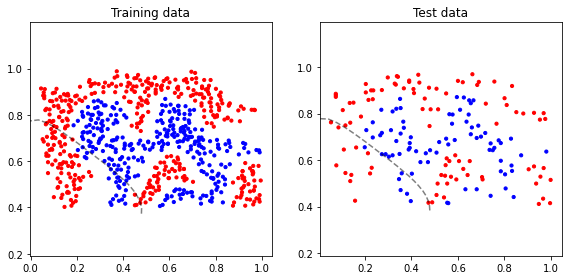

Accuracy: 0.5433526011560693


In [111]:
do_svm(train_X, test_X, train_Y, test_Y, kernel='sigmoid', C=10)

### 4. Omówienie accuracy, cross validation, loss, ROC curve, PR curve

Także w tej samej prezentacji: https://1drv.ms/p/s!Ap19wJ6OUb8YgYMBlXjB0sOhyxqi0Q

### 5. Wizualizacja accuracy, cross validation, loss, ROC curve, PR curve dla zbioru WBC

In [112]:
cancer = load_breast_cancer()

X, y = (cancer.data, cancer.target)

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [113]:
# accuracy:
clf = SVC(kernel='linear', probability=True)
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(f'accuracy = {accuracy_score(y_test,y_pred)}')

accuracy = 0.9090909090909091


In [114]:
#cross validation
scores = cross_val_score(clf, X, y, cv=5)
print(f'cross validations scores:{scores}')

cross validations scores:[0.94736842 0.92982456 0.97368421 0.92105263 0.95575221]


In [115]:
#loss użyto funkcji hinge która jest stosowana w SVM
print(f'hinge function loss: {hinge_loss(y_test, y_pred)}')

hinge function loss: 0.44755244755244755


In [116]:
# precision score
print(f'precision score: {precision_score(y_test, y_pred)}')

precision score: 0.9340659340659341


In [117]:
# recall score
print(f'recall score: {recall_score(y_test, y_pred)}')

recall score: 0.9239130434782609


In [118]:
# f1 score
print(f'f1 score: {f1_score(y_test, y_pred)}')

f1 score: 0.9289617486338797


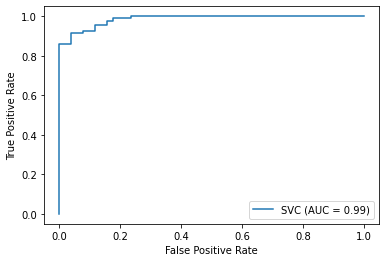

In [119]:
# ROC curve
# Binarize the output
svc_disp = plot_roc_curve(clf, x_test, y_test)
plt.show()

Average precision score, micro-averaged over all classes: 0.96


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.96')

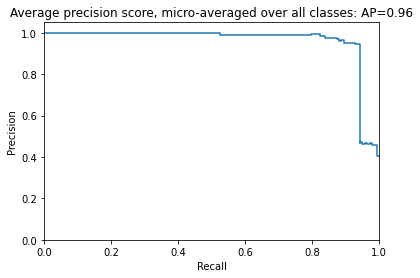

In [120]:
# PR_curve
y_binarized = label_binarize(y, classes=[0, 1, 2])
n_classes = y_binarized.shape[1]

# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X, y_binarized, train_size=0.75)

# Run classifier
classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True))
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_test)

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

### 5. Zadania

a. Na zbiorach MNIST, FMNIST, TNG (twenty news groups) zaprezentować działanie
klasyfikatora SVM i wyniki porównać do klasyfikatora k-NN przy pomocy poznanych miar
walidacji klasyfikacji. (dla najlepszej konfiguracji, stałej uczenia, funkcji kernela)

In [282]:
from sklearn.neighbors import KNeighborsClassifier

In [291]:
def evaluate_svm(X_train, X_test, y_train, y_test, kernel='linear', C=1):
    classifier =  SVC(kernel=kernel, C=C)
    classifier.fit(X_train, y_train)
    y_predicted = classifier.predict(X_test)
    report = classification_report(y_test, y_predicted, output_dict=True)['weighted avg']
    report['name'] = 'SVM, C = {}, kernel: {}'.format(C, kernel)
    report['accuracy'] = report['f1-score']
    del report['f1-score']
    report['accuracy (cross-val)'] = np.mean(cross_val_score(classifier, X_train, y_train, cv=5, scoring='accuracy'))
    return report

In [292]:
def evaluate_knn(X_train, X_test, y_train, y_test, kernel='linear', n_neighbors=5):
    classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier.fit(X_train, y_train)
    y_predicted = classifier.predict(X_test)
    report = classification_report(y_test, y_predicted, output_dict=True)['weighted avg']
    report['name'] = 'kNN, k = {}, kernel: {}'.format(n_neighbors, kernel)
    report['accuracy'] = report['f1-score']
    del report['f1-score']
    report['accuracy (cross-val)'] = np.mean(cross_val_score(classifier, X_train, y_train, cv=5, scoring='accuracy'))
    return report

In [293]:
def get_df_row(report): 
    return pd.DataFrame(report, columns = ['name' ,
                                           'accuracy (cross-val)',
                                           'accuracy',
                                           'precision' ,
                                           'recall',
                                           'support'
                                          ], index=[0])


In [294]:
def evaluate_all(X_train, X_test, y_train, y_test):
    base_df = pd.DataFrame( columns = ['name' ,
                                       'accuracy (cross-val)',
                                       'accuracy',
                                       'precision' ,
                                       'recall',
                                       'support'
                                      ])
    for C in [1, 5]:
        for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
            report = evaluate_svm(X_train, X_test, y_train, y_test, C=C, kernel=kernel)
            base_df = pd.concat([base_df,get_df_row(report)], ignore_index=True)
    for k in [3, 5, 7]:
        for kernel in ['uniform', 'distance']:
            report = evaluate_knn(X_train, X_test, y_train, y_test, n_neighbors=k, kernel=kernel)
            base_df = pd.concat([base_df,get_df_row(report)], ignore_index=True)
    return base_df.sort_values(by='accuracy', ascending=False)

In [315]:
def compare_best(X_train, X_test, y_train, y_test, C, k, knn_kernel, svm_kernel):
    base_df = pd.DataFrame( columns = ['name' ,
                                       'accuracy (cross-val)',
                                       'accuracy',
                                       'precision' ,
                                       'recall',
                                       'support',
                                      ])

    report = evaluate_svm(X_train, X_test, y_train, y_test, C=C, kernel=svm_kernel)
    base_df = pd.concat([base_df,get_df_row(report)], ignore_index=True)
    report = evaluate_knn(X_train, X_test, y_train, y_test, n_neighbors=k, kernel=knn_kernel)
    base_df = pd.concat([base_df,get_df_row(report)], ignore_index=True)
    return base_df.sort_values(by='accuracy', ascending=False)    

In [370]:
def compare_aug(X_train, X_test, X_aug, y_train, y_test, y_aug, C, svm_kernel):
    base_df = pd.DataFrame( columns = ['name' ,
                                       'accuracy (cross-val)',
                                       'accuracy',
                                       'precision' ,
                                       'recall',
                                       'support',
                                      ])

    report = evaluate_svm(X_train, X_test, y_train, y_test, C=C, kernel=svm_kernel)
    base_df = pd.concat([base_df,get_df_row(report)], ignore_index=True)
    report = evaluate_svm(X_aug, X_test, y_aug, y_test, C=C, kernel=svm_kernel)
    report['name'] = report['name'] + ' AUGMENTED'
    base_df = pd.concat([base_df,get_df_row(report)], ignore_index=True)
    return base_df.sort_values(by='accuracy', ascending=False)  

### MNIST

In [321]:
mnist = fetch_openml("mnist_784", data_home="./mnist_784", cache=True)

In [334]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [324]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, train_size=0.008, test_size=0.002, random_state=1)

In [325]:
evaluate_all(X_train, X_test, y_train, y_test)

,name,accuracy (cross-val),accuracy,precision,recall,support
6,"SVM, C = 5, kernel: rbf",0.898214,0.864221,0.874909,0.864286,140
2,"SVM, C = 1, kernel: rbf",0.885714,0.847333,0.863135,0.850000,140
5,"SVM, C = 5, kernel: poly",0.835714,0.830633,0.848176,0.828571,140
0,"SVM, C = 1, kernel: linear",0.844643,0.828827,0.840569,0.828571,140
4,"SVM, C = 5, kernel: linear",0.844643,0.828827,0.840569,0.828571,140
10,"kNN, k = 5, kernel: uniform",0.832143,0.828014,0.850191,0.828571,140
11,"kNN, k = 5, kernel: distance",0.832143,0.828014,0.850191,0.828571,140
8,"kNN, k = 3, kernel: uniform",0.858929,0.815582,0.841369,0.814286,140
9,"kNN, k = 3, kernel: distance",0.858929,0.815582,0.841369,0.814286,140
12,"kNN, k = 7, kernel: uniform",0.830357,0.813520,0.841455,0.814286,140


In [498]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, train_size=0.08, test_size=0.02, random_state=1)

In [499]:
X_train.shape

(5600, 784)

In [500]:
X_test.shape

(1400, 784)

In [327]:
compare_best(X_train, X_test, y_train, y_test, C=5, k=5, knn_kernel='uniform', svm_kernel='rbf')

,name,accuracy (cross-val),accuracy,precision,recall,support
0,"SVM, C = 5, kernel: rbf",0.950893,0.954164,0.954397,0.954286,1400
1,"kNN, k = 5, kernel: uniform",0.924107,0.933531,0.936865,0.933571,1400


### FMNIST

In [ ]:
fmnist = fetch_openml("Fashion-MNIST", data_home="./fmnist", cache=True)

In [335]:
print(fmnist.DESCR)

**Author**: Han Xiao, Kashif Rasul, Roland Vollgraf  
**Source**: [Zalando Research](https://github.com/zalandoresearch/fashion-mnist)  
**Please cite**: Han Xiao and Kashif Rasul and Roland Vollgraf, Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms, arXiv, cs.LG/1708.07747  

Fashion-MNIST is a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. 

Raw data available at: https://github.com/zalandoresearch/fashion-mnist

### Target classes
Each training and test example is assigned to one of the following labels:
Label  Description  
0  T-shirt/top  
1  Trouser  
2  Pullover  
3  Dress  
4  

In [329]:
X_train, X_test, y_train, y_test = train_test_split(fmnist.data, fmnist.target, train_size=0.008, test_size=0.002, random_state=1)

In [330]:
evaluate_all(X_train, X_test, y_train, y_test)

,name,accuracy (cross-val),accuracy,precision,recall,support
6,"SVM, C = 5, kernel: rbf",0.785714,0.776058,0.802941,0.771429,140
0,"SVM, C = 1, kernel: linear",0.775000,0.765107,0.793014,0.764286,140
4,"SVM, C = 5, kernel: linear",0.775000,0.765107,0.793014,0.764286,140
2,"SVM, C = 1, kernel: rbf",0.755357,0.763450,0.789954,0.764286,140
5,"SVM, C = 5, kernel: poly",0.716071,0.747026,0.800606,0.735714,140
12,"kNN, k = 7, kernel: uniform",0.723214,0.708173,0.762410,0.700000,140
13,"kNN, k = 7, kernel: distance",0.723214,0.708173,0.762410,0.700000,140
10,"kNN, k = 5, kernel: uniform",0.733929,0.706168,0.749752,0.700000,140
11,"kNN, k = 5, kernel: distance",0.733929,0.706168,0.749752,0.700000,140
8,"kNN, k = 3, kernel: uniform",0.746429,0.683823,0.747556,0.678571,140


In [501]:
X_train, X_test, y_train, y_test = train_test_split(fmnist.data, fmnist.target, train_size=0.08, test_size=0.02, random_state=1)

In [502]:
X_train.shape

(5600, 784)

In [503]:
X_test.shape

(1400, 784)

In [332]:
compare_best(X_train, X_test, y_train, y_test, C=5, k=7, knn_kernel='uniform', svm_kernel='rbf')

,name,accuracy (cross-val),accuracy,precision,recall,support
0,"SVM, C = 5, kernel: rbf",0.865893,0.877547,0.878237,0.878571,1400
1,"kNN, k = 7, kernel: uniform",0.820179,0.817433,0.825631,0.817857,1400


### 20 newsgroups text dataset

In [305]:
from sklearn.datasets import fetch_20newsgroups_vectorized

In [306]:
twenty_dataset = fetch_20newsgroups_vectorized(subset='all', data_home="./20ng")

In [336]:
print(twenty_dataset.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality 

In [504]:
X_train, X_test, y_train, y_test = train_test_split(twenty_dataset.data, twenty_dataset.target, train_size=0.032, test_size=0.008, random_state=1)

In [505]:
X_train.shape

(603, 130107)

In [506]:
X_test.shape

(151, 130107)

In [310]:
evaluate_all(X_train, X_test, y_train, y_test)

,name,accuracy (cross-val),accuracy,precision,recall,support
4,"SVM, C = 5, kernel: linear",0.446171,0.484900,0.487396,0.503311,151
7,"SVM, C = 5, kernel: sigmoid",0.441185,0.476127,0.488794,0.496689,151
6,"SVM, C = 5, kernel: rbf",0.389738,0.450753,0.474223,0.476821,151
5,"SVM, C = 5, kernel: poly",0.331680,0.361820,0.417017,0.410596,151
0,"SVM, C = 1, kernel: linear",0.316777,0.361302,0.394689,0.410596,151
1,"SVM, C = 1, kernel: poly",0.281887,0.323327,0.344941,0.390728,151
3,"SVM, C = 1, kernel: sigmoid",0.278636,0.322072,0.367797,0.370861,151
2,"SVM, C = 1, kernel: rbf",0.286956,0.311935,0.363719,0.390728,151
8,"kNN, k = 3, kernel: uniform",0.190661,0.215388,0.255031,0.238411,151
9,"kNN, k = 3, kernel: distance",0.190661,0.215388,0.255031,0.238411,151


In [343]:
X_train, X_test, y_train, y_test = train_test_split(twenty_dataset.data, twenty_dataset.target, train_size=0.16, test_size=0.04, random_state=1)

In [318]:
compare_best(X_train, X_test, y_train, y_test, C=5, k=5, knn_kernel='uniform', svm_kernel='linear')

,name,accuracy (cross-val),accuracy,precision,recall,support
0,"SVM, C = 5, kernel: linear",0.713765,0.731313,0.739025,0.729443,754
1,"kNN, k = 5, kernel: uniform",0.358541,0.360705,0.437401,0.362069,754


b. Zaproponować, taką augmentację zbiorów treningowych (wielkość zbioru zależna od
mocy obliczeniowej którą Państwo dysponują) aby uzyskać jak najlepsze miary jakości na
zbiorach testowych.

In [435]:
from imgaug import augmenters as iaa
import scipy

In [413]:
def get_aug(X_train, y_train, a_coeff=0.5):
    seq = iaa.Sequential([
       iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 120), per_channel=0.5)),
       iaa.Affine(rotate=(-5, 5)),
    ])
    n_samples = int(a_coeff*len(X_train))
    samples_to_aug = random.sample(range(len(X_train)), n_samples)
    images = [np.array(X_train[i], dtype='float32').reshape(28,28) for i in samples_to_aug]
    new_images = seq(images=images)
    X_aug = np.array([im.reshape(784) for im in images])
    y_aug = np.array([y_train[i] for i in samples_to_aug])
    X_train_e = np.append(X_train, X_aug, axis=0)
    y_train_e = np.append(y_train, y_aug, axis=0)
    return X_train_e, y_train_e

In [489]:
def get_aug_tng(X_train, y_train, a_coeff=0.5):
    n_samples = int(a_coeff*X_train.shape[0])
    samples_to_aug = random.sample(range(X_train.shape[0]), n_samples)
    
    for i in samples_to_aug:
        X = X_train[i].copy()
        for j in X.nonzero()[1]:
            X[0, j] = X[0, j] * (1. + random.uniform(-1, 1)/10.0)
        X_train = scipy.sparse.vstack((X_train, X))
    
    X_train_e = X_train    
    y_aug = np.array([y_train[i] for i in samples_to_aug])
    y_train_e = np.append(y_train, y_aug, axis=0)
    
    return X_train_e, y_train_e

### FMNIST

In [507]:
X_train, X_test, y_train, y_test = train_test_split(fmnist.data, fmnist.target, train_size=0.02, test_size=0.005, random_state=1)

In [508]:
X_train.shape

(1400, 784)

In [509]:
X_test.shape

(350, 784)

In [415]:
X_aug, y_aug = get_aug(X_train, y_train)

In [416]:
compare_aug(X_train, X_test, X_aug, y_train, y_test, y_aug, C=5, svm_kernel='rbf')

,name,accuracy (cross-val),accuracy,precision,recall,support
1,"SVM, C = 5, kernel: rbf AUGMENTED",0.930000,0.855305,0.861101,0.854286,350
0,"SVM, C = 5, kernel: rbf",0.832857,0.847482,0.853352,0.845714,350


### MNIST

In [511]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, train_size=0.02, test_size=0.005, random_state=1)

In [512]:
X_train.shape

(1400, 784)

In [513]:
X_test.shape

(350, 784)

In [421]:
X_aug, y_aug = get_aug(X_train, y_train, a_coeff)

In [422]:
compare_aug(X_train, X_test, X_aug, y_train, y_test, y_aug, C=5, svm_kernel='rbf')

,name,accuracy (cross-val),accuracy,precision,recall,support
1,"SVM, C = 5, kernel: rbf AUGMENTED",0.948810,0.920094,0.922109,0.920000,350
0,"SVM, C = 5, kernel: rbf",0.926429,0.917164,0.919076,0.917143,350


### TNG

In [514]:
X_train, X_test, y_train, y_test = train_test_split(twenty_dataset.data, twenty_dataset.target, train_size=0.16, test_size=0.04, random_state=1)

In [515]:
X_train.shape

(3015, 130107)

In [516]:
X_test.shape

(754, 130107)

In [496]:
X_aug, y_aug = get_aug_tng(X_train, y_train)

In [497]:
compare_aug(X_train, X_test, X_aug, y_train, y_test, y_aug, C=5, svm_kernel='linear')

,name,accuracy (cross-val),accuracy,precision,recall,support
1,"SVM, C = 5, kernel: linear AUGMENTED",0.896966,0.734901,0.743886,0.732095,754
0,"SVM, C = 5, kernel: linear",0.713765,0.731313,0.739025,0.729443,754
